<a href="https://colab.research.google.com/github/AlvinChiew/MachineLearning/blob/main/Sklearn_D_Reduction_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Principle Component Analysis
- Derive "principle component" from raw data (orthogonal components which explains highest variances in data). Then distribute data across PC (derived feature) to form new perspective of dataset
- Remove insignificant PC by recoordinating data point to 0. Such simplifies the model with fewer feature to consider.
- Then translate the data back from PC to features. The data now has simpler geometry. Prediction becomes simpler and more straightforward


# Import Module

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.datasets import fetch_lfw_people

# Load Data & Pre-Process

In [2]:
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

In [3]:
print(people.DESCR)

.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

    http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in the OpenC

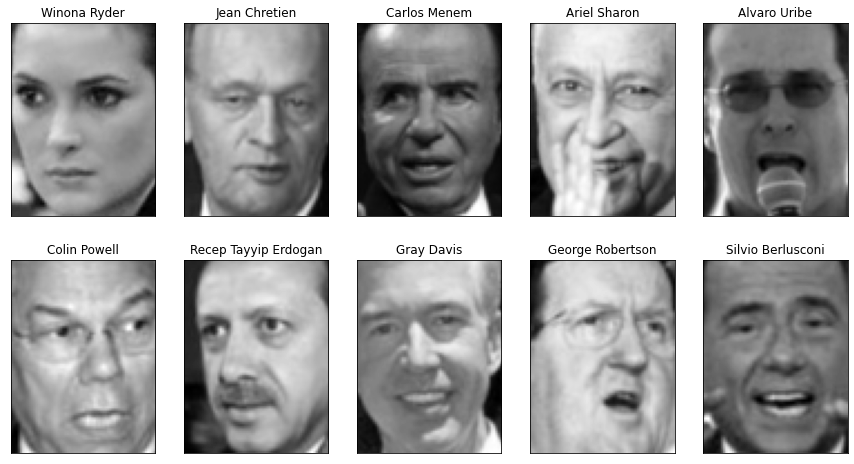

In [4]:
# Show 10 raw samples
fig,axes=plt.subplots(2,5, figsize=(15,8), 
                     subplot_kw={'xticks':(), 'yticks':()})
for t,im,ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(im, cmap='gray')
    ax.set_title(people.target_names[t])

In [5]:
print(f"Input (image) size : {people.images.shape}")            # 3,023 samples,87 x 65 pixels
print(f"target (name) size : {people.target_names.shape}")      # 62 records of people

Input (image) size : (3023, 87, 65)
target (name) size : (62,)


In [6]:
# Check sample distribution

### Py Dictionary Way ###
# peoples = {}
# for i in people.target:    
#     peoples[i] = peoples.get(i, 0) + 1
# peoples

## Numpy Way ###
person, counts = np.unique(people.target, return_counts=True)
people_collection = dict(zip(person, counts))     # people-to-sample-count mapping

print(f"Min # sample by person : {counts.min()}")   # people_collection.values()
print(f"Max # sample by person : {counts.max()}")
#print(f"Mean # sample by person : {counts.mean():.1f}")

Min # sample by person : 20
Max # sample by person : 530


<BarContainer object of 62 artists>

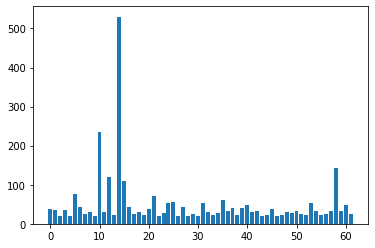

In [7]:
# Plot sample distribution
plt.bar(person, counts)

In [8]:
person_most_sample = max(people_collection, key=people_collection.get)
print(f'Person with Most # Samples : {people.target_names[person_most_sample]}')

Person with Most # Samples : George W Bush


In [9]:
# Process skewed dataset by filtering sample to only take max 50 sample from each person

filter = np.zeros(people.target.shape, dtype=np.bool)
for p in np.unique(people.target):
    filter[np.where(people.target==p)[0][:50]] = 1

X = people.data[filter] / 255       # scale pixel value to 0 ~ 1;   1 pixel = 0 ~ 255 in grayscale
y = people.target[filter]

print(f'Ori sample size = {people.data.shape}')
print(f'New sample size = {y.shape}')
print(f'New input size = {X.shape}')

Ori sample size = (3023, 5655)
New sample size = (2063,)
New input size = (2063, 5655)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# Train Model

* CNN is better in pattern searching for image classification but deep learning requires way larger dataset.
* For the sake of simplicity, KNN is used to show how PCA can boost model accuracy. Ensemble method might be better but let's keep it simple
* Reading: https://medium.com/swlh/image-classification-using-machine-learning-and-deep-learning-2b18bfe4693f


In [11]:
classifier = KNeighborsClassifier(n_neighbors=1)

## Before PCA

In [17]:
model = classifier.fit(X_train, y_train)

## After PCA

In [20]:
pca = PCA(n_components=100, whiten=True, random_state=0)    # Whiten to make the input less redundant as adjacent pixel values are highly correlated; turn pixels into less correlated with each other, and all share the same variance.
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [21]:
model_pca = classifier.fit(X_train_pca, y_train)

# Evaluation

In [18]:
print(f'Train score : {model.score(X_train, y_train)}')
print(f'Test score : {model.score(X_test, y_test)}')

# KNN is overfitting as it sees all pixels (features) equally important. PCA can help by removing insignificant pixel that doesn't help in pattern searching

Train score : 1.0
Test score : 0.23255813953488372


In [22]:
print(f'Train score : {model_pca.score(X_train_pca, y_train)}')
print(f'Test score : {model_pca.score(X_test_pca, y_test)}')

# KNN is still overfitting but we can see improvement in Test score when redundant pixels/features are reduced

Train score : 1.0
Test score : 0.312015503875969


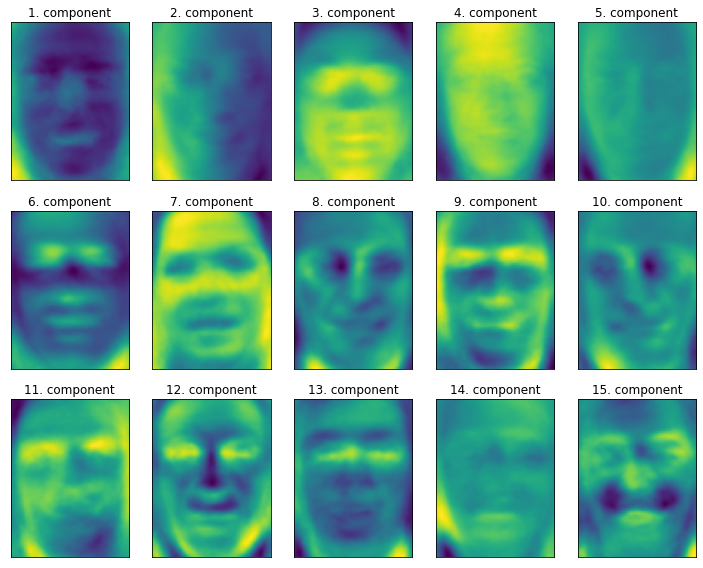

In [23]:
# Plot how pixels/features are merged for each component in PCA
fig,axes=plt.subplots(3,5, figsize=(10,8), 
                     subplot_kw={'xticks':(), 'yticks':()})
axes=axes.ravel()
for i in range(len(axes)):
    axes[i].imshow(pca.components_[i].reshape(people.images[0].shape), 
                   cmap='viridis')
    axes[i].set_title('%d. component'%(i+1))

fig.tight_layout()

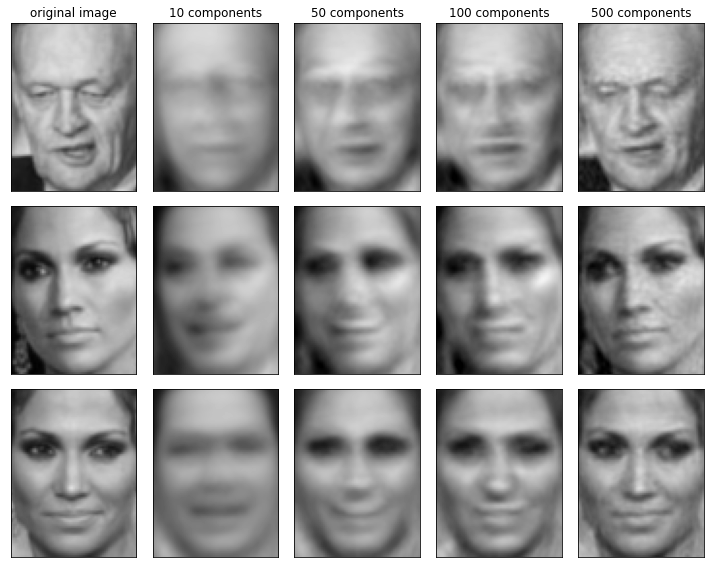

In [24]:
# Show the resuled images from pixel/feature reduction via PCA in range of [10, 50, 100, 500] components

def pca_faces(X_train, X_test):
    reduced_images = []
    for n_components in [10, 50, 100, 500]:
        pca = PCA(n_components=n_components)
        pca.fit(X_train)
        X_test_pca = pca.transform(X_test)
        X_test_back = pca.inverse_transform(X_test_pca)
        reduced_images.append(X_test_back)
    return reduced_images


reduced_images = pca_faces(X_train, X_test)
fig,axes=plt.subplots(3,5, figsize=(10,8), 
                     subplot_kw={'xticks':(), 'yticks':()})
for i, ax in enumerate(axes):
        # plot original image
        ax[0].imshow(X_test[i].reshape(people.images[0].shape),
                     vmin=0, vmax=1, cmap='gray')
        # plot the four back-transformed images
        for a, X_test_back in zip(ax[1:], reduced_images):
            a.imshow(X_test_back[i].reshape(people.images[0].shape), 
                     vmin=0, vmax=1, cmap='gray')

        axes[0, 0].set_title("original image")
        for ax, n_components in zip(axes[0, 1:], [10, 50, 100, 500]):
            ax.set_title(f"{n_components} components")
fig.tight_layout()
plt.show()

# We can already have a good guess of the person with 100 components and almost raw at 500 components comparing to 87 x 65 = 5,655 pixels/features from raw images.
# Something worth comparing : PCA vs Max Pooling (even simpler implementation)

# Extra: Methodology Illustration 

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA           # Linear dimensionality reduction using Singular Value Decomposition of the data

In [26]:
# Dummy Data
rnd = np.random.RandomState(5)
X_rnd = rnd.normal(size=(300, 2))       # normally distribute 300 points on 2D graph
X = np.dot(X_rnd, rnd.normal(size=(2, 2))) + rnd.normal(size=2)     # strech data points thinner and shorten data range by half
X.shape

(300, 2)

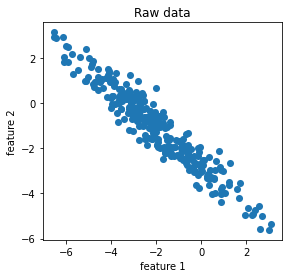

In [27]:
# Raw Data
fig, ax = plt.subplots(1,1)
ax.scatter(X[:, 0], X[:, 1], linewidths=0, s=50)
ax.set_title("Raw data")
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
ax.set_aspect('equal')

In [28]:
# Apply PCA

pca = PCA()
pca.fit(X)
X_pca  = pca.transform(X)
X_pca_std = X_pca.std(axis=0)

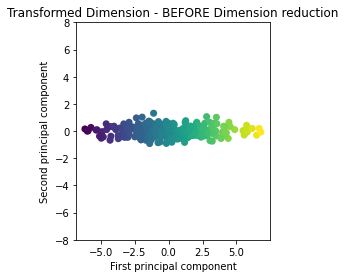

In [29]:
# Illustrate PCA Result on PC Perspective BEFORE dimensionality reduction

fig, ax = plt.subplots(1,1)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=X_pca[:, 0], linewidths=0,
                s=50, cmap='viridis')
ax.set_title("Transformed Dimension - BEFORE Dimension reduction")
ax.set_xlabel("First principal component")
ax.set_ylabel("Second principal component")
ax.set_ylim(-8, 8)
ax.set_aspect('equal')

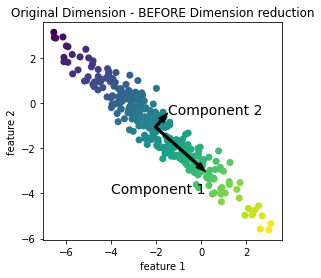

In [30]:
# Translate PCA result into Raw data perspective BEFORE dimensionality reduction 

fig, ax = plt.subplots(1,1)
ax.scatter(X[:, 0], X[:, 1], c=X_pca[:, 0],     # Later in conclusion, we know first PC is major. So data is colored by the range of the order of first PC
           linewidths=0, s=50, cmap='viridis')
ax.set_title("Original Dimension - BEFORE Dimension reduction")
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
ax.arrow(pca.mean_[0], pca.mean_[1], X_pca_std[0] * pca.components_[0, 0],     # arrow represents PCA component's origin, direction and stand. dev.
         X_pca_std[0] * pca.components_[0, 1], width=.1, head_width=.3,
         color='k')
ax.arrow(pca.mean_[0], pca.mean_[1], X_pca_std[1] * pca.components_[1, 0],
         X_pca_std[1] * pca.components_[1, 1], width=.1, head_width=.3,
         color='k')
ax.text(-1.5, -.5, "Component 2", size=14)
ax.text(-4, -4, "Component 1", size=14)
ax.set_aspect('equal')

# PC directs orthogonally towards the direction where data variates the most

In [31]:
# Reduce one dimension through PCA

pca = PCA(n_components=1) 
pca.fit(X)
X_inverse = pca.inverse_transform(pca.transform(X))     # Get X coordinate after dimention reduction

(-8.0, 8.0)

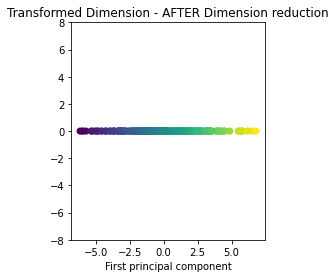

In [32]:
# Illustrate PCA Result on PC Perspective AFTER reducing dimensionality to 1

ig, ax = plt.subplots(1,1)
ax.scatter(X_pca[:, 0], np.zeros(X_pca.shape[0]), c=X_pca[:, 0],
           linewidths=0, s=50, cmap='viridis')
ax.set_title("Transformed Dimension - AFTER Dimension reduction")
ax.set_xlabel("First principal component")
ax.set_aspect('equal')
ax.set_ylim(-8, 8)

# Second PC is eliminated as the data range is significantly smaller than that of First PC

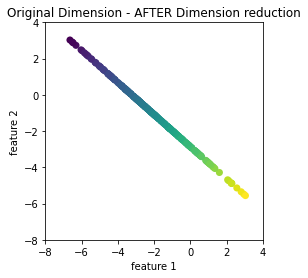

In [33]:
# Translate PCA result into Raw data perspective AFTER reducing dimensionality to 1

fig, ax = plt.subplots(1,1)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], c=X_pca[:, 0],
           linewidths=0, s=50, cmap='viridis')
ax.set_title("Original Dimension - AFTER Dimension reduction")
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
ax.set_aspect('equal')
ax.set_xlim(-8, 4)
ax.set_ylim(-8, 4)
plt.show()

# PCA concluded that PC 2 does not contribute much in differing data into separate classes.